In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from nbformat import read
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [4]:
X_y_train = np.load('X_y_train.npy')
X_y_train.shape

(1000000, 10)

In [5]:
X_y_test = np.load('X_y_test.npy')
X_y_test.shape

(200000, 10)

In [6]:
X_train = X_y_train[:, :-1]  # Features
X_test = X_y_test[:, :-1]  # Features

y_train = X_y_train[:, -1]  # Labels
y_test = X_y_test[:, -1]  # Labels

### Metric

our favorable metric is recall, beacuse our label consist mostly of 0 and it is important for us that the model can find these nonzero labels and don't predict 0 everywhere

## Linear Regressin Model

In [18]:
linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred_lr = linear_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred_lr)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.007436262439837846


### Confusion matrix

In [26]:
# Transform probabilities into binary predictions using a threshold (0.5)
linear_preds_binary = (y_pred_lr > 0).astype(int)

conf_matrix_linear = confusion_matrix(y_test, linear_preds_binary)

print("Confusion Matrix for Linear Regression:")
print()
print(conf_matrix_linear)
print()

accuracy_lr = accuracy_score(y_test, linear_preds_binary)

precision_lr = precision_score(y_test, linear_preds_binary)

recall_lr = recall_score(y_test, linear_preds_binary)

f1_lr = f1_score(y_test, linear_preds_binary)

print(f'recall_lr = {recall_lr}')
print()
#print('recall is 0,hence this model is not doing good')
print(f1_lr)

Confusion Matrix for Linear Regression:

[[ 60302 138175]
 [     0   1523]]

recall_lr = 1.0

0.021569030101755406


### Linear regression learning curve

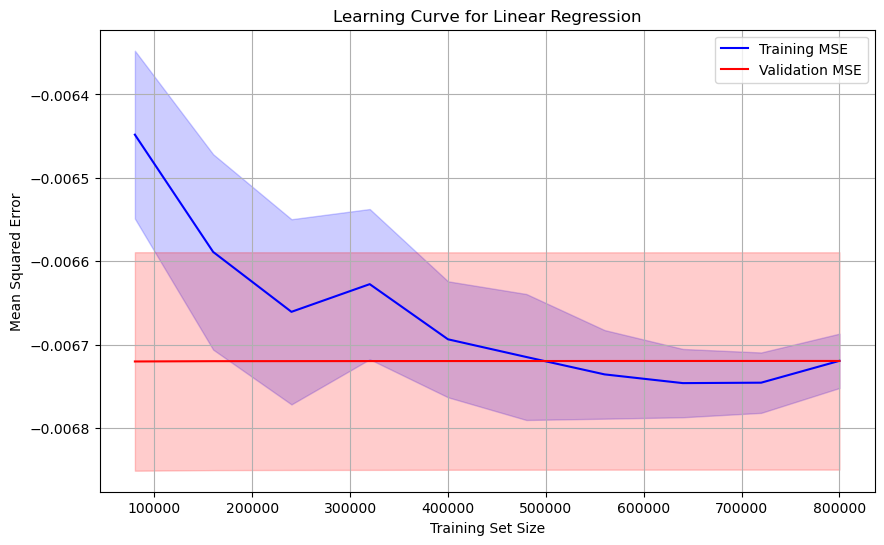

In [20]:
train_sizes, train_scores, valid_scores = learning_curve(
    linear_regressor, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error'
)

# Calculate mean and standard deviation of training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training MSE', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, valid_mean, label='Validation MSE', color='red')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='red')
plt.title('Learning Curve for Linear Regression')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

## Decision Tree Model

In [21]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)

print("Decision Tree Mean Squared Error:", mse_dt)

Decision Tree Mean Squared Error: 0.014185


### Confussion matrix

In [22]:
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("Confusion Matrix for Decision Tree:")
print()
print(conf_matrix_dt)
print()

accuracy_dt = accuracy_score(y_test, y_pred_dt)

precision_dt = precision_score(y_test, y_pred_dt)

recall_dt = recall_score(y_test, y_pred_dt)

f1_dt = f1_score(y_test, y_pred_dt)

print(f'recall_dt = {recall_dt}')
print()

#recall is not zero and is better than other models

Confusion Matrix for Decision Tree:

[[196943   1534]
 [  1303    220]]

recall_dt = 0.14445173998686803



### decision tree tuning and evaluation

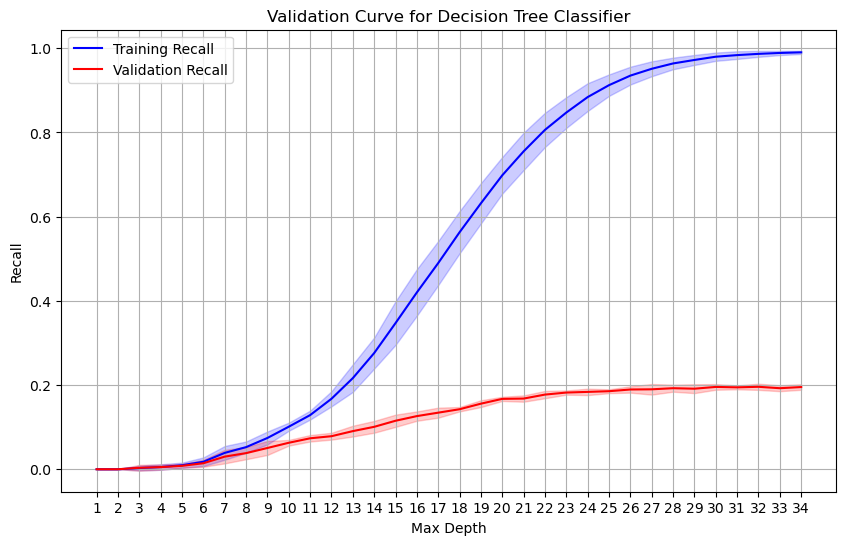

In [24]:
tree_classifier = DecisionTreeClassifier()

# Define the range of values for the hyperparameter to tune (e.g., max_depth)
param_range = np.arange(1, 35)

# Define recall as the scoring metric
scorer = make_scorer(recall_score)

# Compute validation curve
train_scores, valid_scores = validation_curve(
    tree_classifier, X_train, y_train, param_name='max_depth', param_range=param_range, cv=5, scoring=scorer
)

# Calculate mean and standard deviation of training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training Recall', color='blue')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(param_range, valid_mean, label='Validation Recall', color='red')
plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='red')
plt.title('Validation Curve for Decision Tree Classifier')
plt.xlabel('Max Depth')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.xticks(param_range)
plt.show()

### DT learning curve

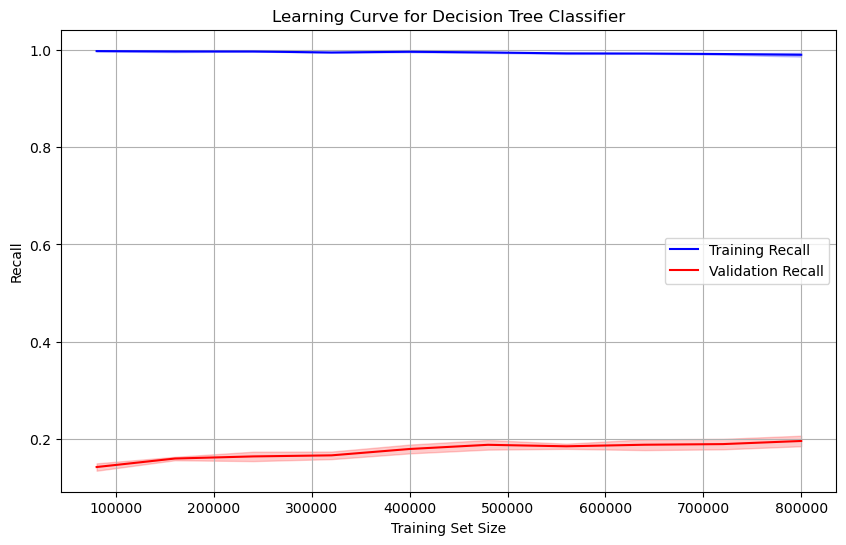

In [25]:
#max depth=28 is the best performance of DT model(concluded from validation curve)
tree_classifier = DecisionTreeClassifier(max_depth=34)
# Define train sizes
train_sizes = np.linspace(0.1, 1.0, 10)

recall_scorer = make_scorer(recall_score)

# Use the learning_curve function with the custom scoring function
train_sizes, train_scores, valid_scores = learning_curve(
    tree_classifier, X_train, y_train, train_sizes=train_sizes, cv=5, scoring=recall_scorer)


# Calculate mean and standard deviation of training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Recall', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, valid_mean, label='Validation Recall', color='red')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='red')
plt.title('Learning Curve for Decision Tree Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()